In [12]:
# Imports
from PrettyShortML import PrettyShortML as psml
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [13]:
# Load in sample data: regression problem
random_state = 42
n_samples, n_features, n_informative = (
    3000,
    15,
    7,
)
X, y = make_regression(
    n_samples,
    n_features,
    n_informative=n_informative,
    bias=500,
    noise=150,
    random_state=random_state,
)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
# Also, Sklearn does not like int columns
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)
X, y

(             0         1         2         3         4         5         6  \
 0     1.181833  2.288399 -0.398440  0.491735 -0.919125  0.131767  1.240527   
 1    -0.540320  0.777929  1.320043  0.112248 -1.794765  0.753056 -1.128859   
 2    -0.450368  0.635727  0.127927 -0.499248 -1.426649 -0.379624 -2.801912   
 3     0.246118  1.450799 -0.588153 -1.117142  0.138193  0.102965  1.201417   
 4    -1.580452  0.329314  0.303069 -0.708213  0.873546 -0.202274 -0.688340   
 ...        ...       ...       ...       ...       ...       ...       ...   
 2995  0.397047  0.464251  1.972344  0.609136 -1.909197 -1.285864  0.058213   
 2996 -0.428145  1.972580 -0.014944 -0.796290 -0.281212  2.274094  1.504213   
 2997  0.029977 -1.054836 -0.616253  0.808803 -0.460236  0.950790 -0.481282   
 2998  0.823546 -1.211768  0.949166  0.676838 -0.611829 -0.109655  0.846854   
 2999 -0.072547  0.212170  0.393495 -0.869220  0.261633  1.245588  0.428772   
 
              7         8         9        10     

Inspect dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3000 non-null   float64
 1   1       3000 non-null   float64
 2   2       3000 non-null   float64
 3   3       3000 non-null   float64
 4   4       3000 non-null   float64
 5   5       3000 non-null   float64
 6   6       3000 non-null   float64
 7   7       3000 non-null   float64
 8   8       3000 non-null   float64
 9   9       3000 non-null   float64
 10  10      3000 non-null   float64
 11  11      3000 non-null   float64
 12  12      3000 non-null   float64
 13  13      3000 non-null   float64
 14  14      3000 non-null   float64
dtypes: float64(15)
memory usage: 351.7 KB
None


Inspect descriptive statistics:
                 0            1            2            3            4  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean      0.005463

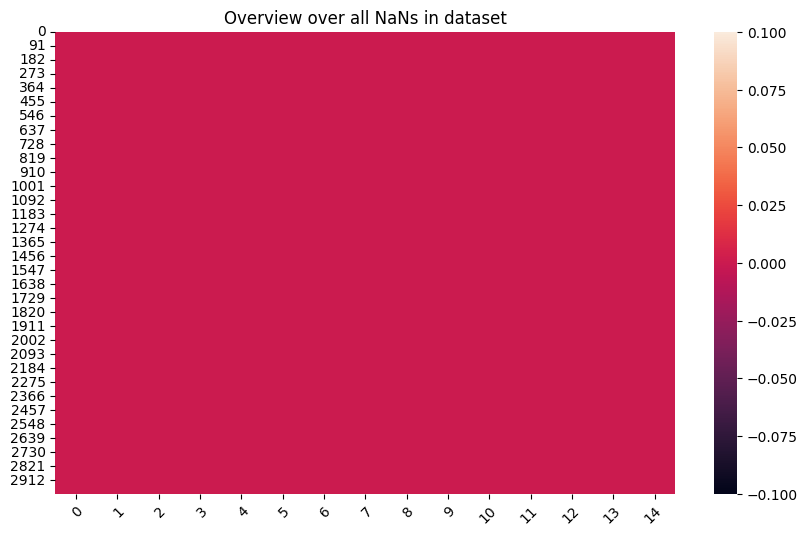

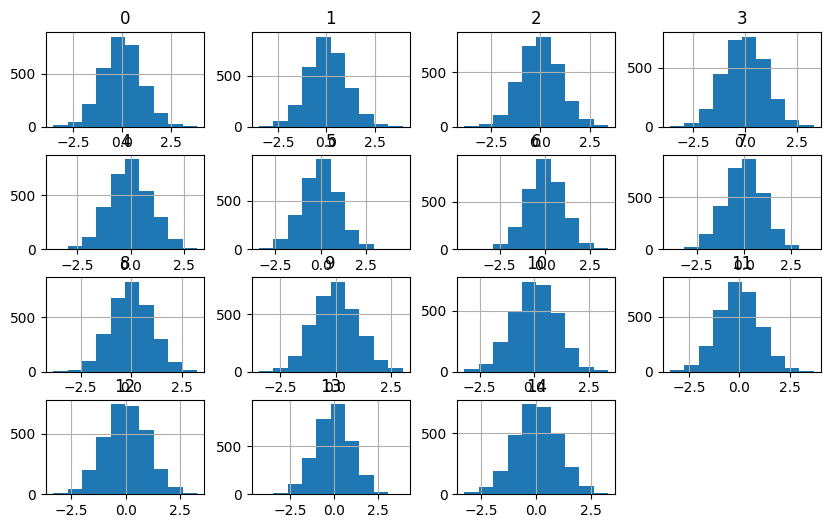

In [14]:
# Do basic EDA
psml.eda_clean_check(X)


In [15]:
# This data is workable, so let's load a class instance after doing a train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)
my_dataset = psml(
    X_train=data_train,
    X_test=data_test,
    y_train=labels_train,
    y_test=labels_test,
)

Starting to plot pairplots. Depending on the dateset size, this may take a while... 
Should it take too long, consider changing the default 'kind' parameter to something else than 'reg'.


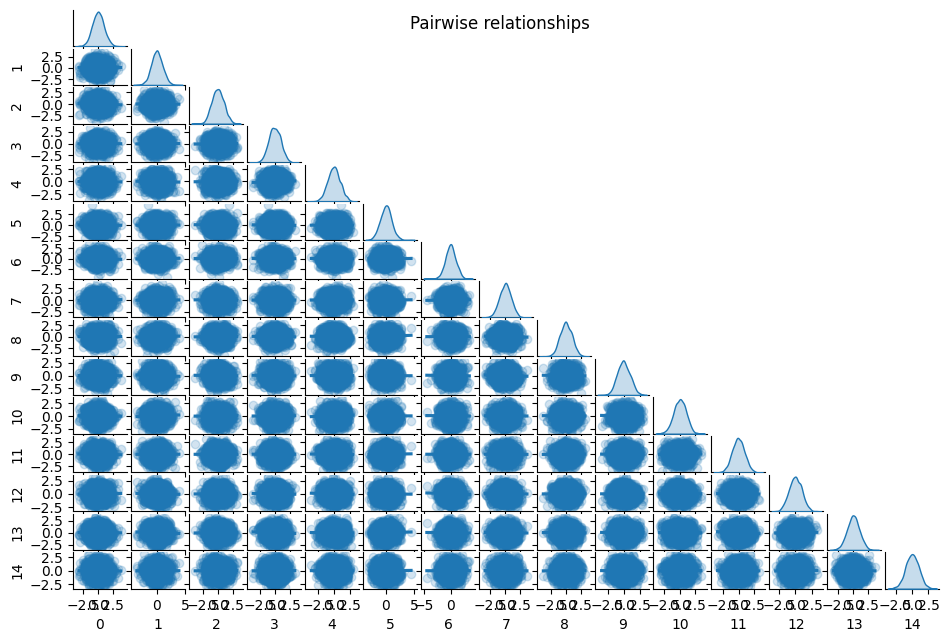

In [16]:
# Plot feature pair plots to inspect distributions and linear relationships
_plotting_ax = psml.plot_eda_pairplot(
    my_dataset.X_train, corner=True, dropna=False, plot_hist=False, fig_size=(9, 6)
)

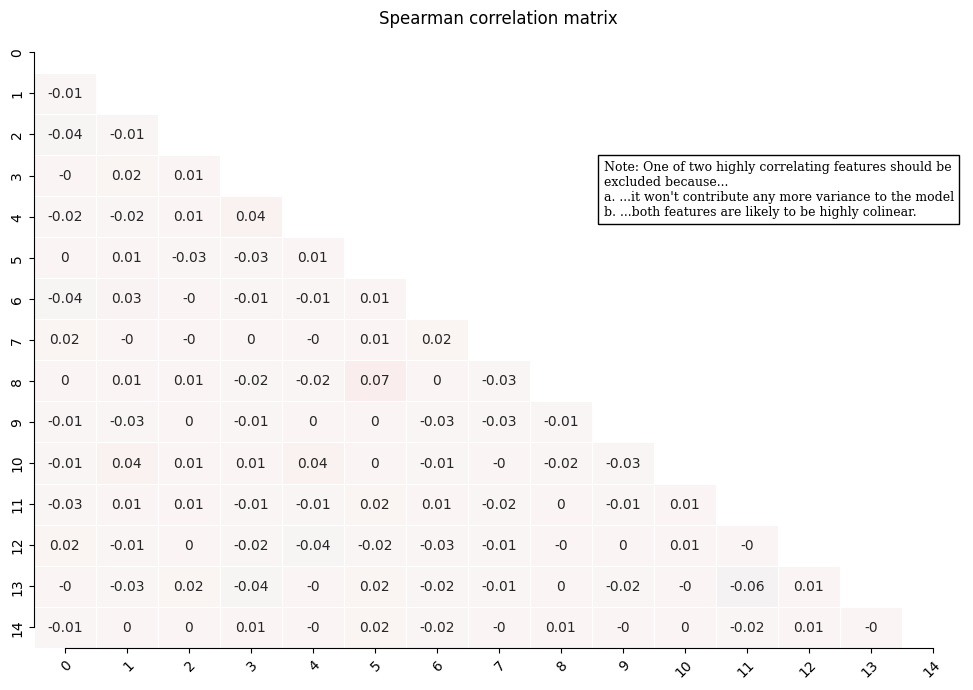

In [17]:
# Plot feature correlation matrix to spot colinearity
_plotting_ax = psml.plot_eda_corr_mat(
    my_dataset.X_train, metric="spearman", cmap="vlag", mask=True, annot=True
)


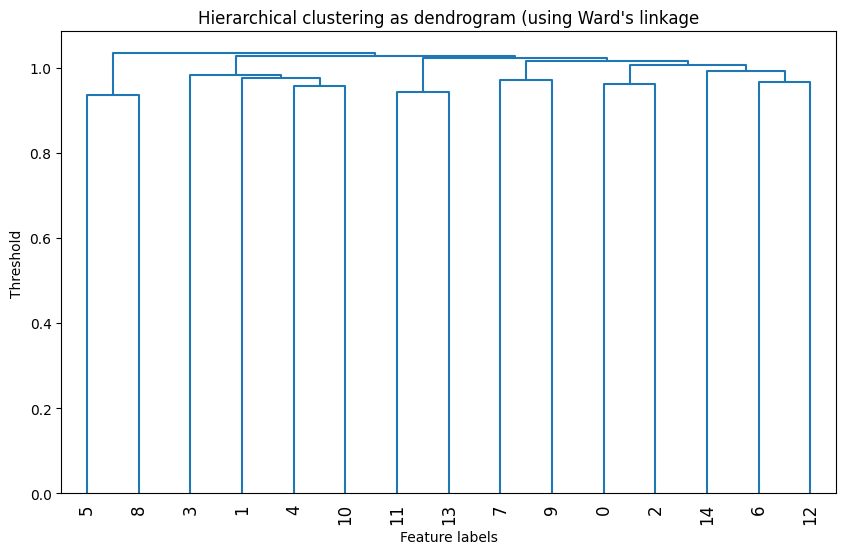

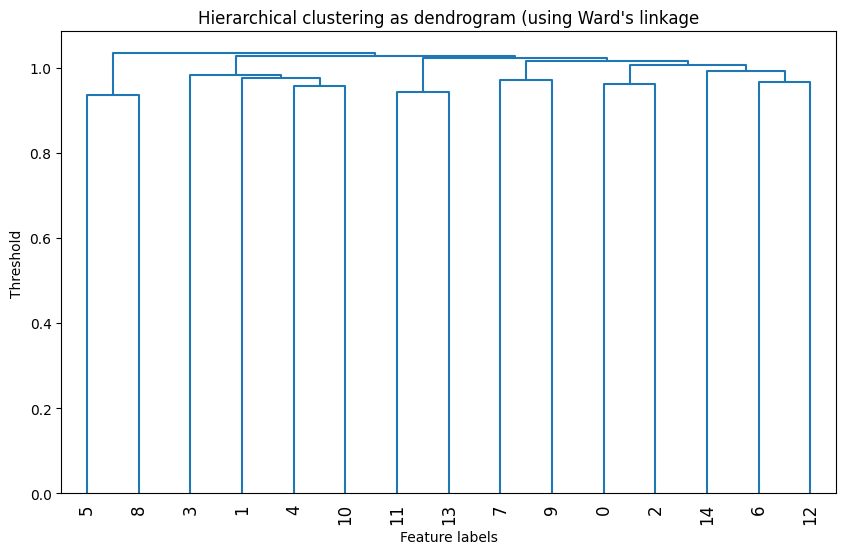

In [18]:
# Normally, we'd do a decent amount of feature cleaning and engineering here.
# For now, let's just do hierarchical clustering on the features' rank-order correlations
# to select features.
_plotting_ax, dist_linkage = psml.plot_hierarchical_clustering(data=my_dataset.X_train)
selected_features = psml.cluster_informed_feature_selection(
    data=my_dataset.X_train, cluster_threshold=0.5
)
# Select the features
my_dataset.X_train = my_dataset.X_train.iloc[:, selected_features]
my_dataset.X_test = my_dataset.X_test.iloc[:, selected_features]

In [19]:
# let's train the model now using a CV splitter and some
# params to do gridsearch. Model_train runs SimpleImputer and StandardScaler on default
# for numerical features. We can use the instance instead of passing the data explicitly.
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=random_state)
param_grid = {
    "estimator__fit_intercept": (True, False),
}
pipeline, training_score = my_dataset.model_train(
    LinearRegression(),
    numeric_features=tuple(my_dataset.X_train.columns),
    param_grid=param_grid,
    cv=cv_splitter,
    n_jobs=-1,
)
print(f"The model's performance on training data:\n{training_score:.4f}")

Building and fitting LinearRegression estimator...
set_config() got an unexpected keyword argument 'transform_output' Couldn't set sklearn's set_config. Is your sklearn version 1.2+ ?
model_train took 0.817 secs to run.

The model's performance on training data:
0.6069


In [20]:
# Let's evaluate our model on the test data
# The evaluation function for regressions isn't implemented yet.

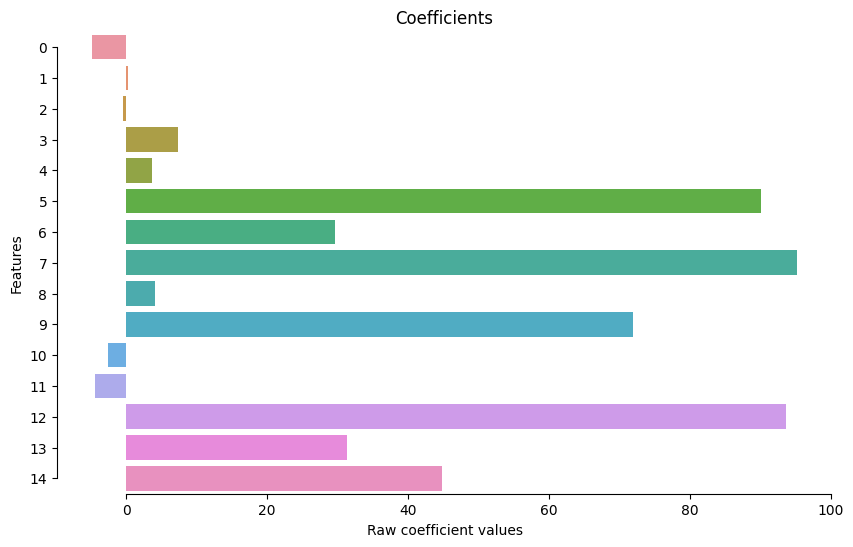

In [21]:
# Let's plot our coefficients
_plotting_ax = psml.plot_reg_coefficients(
    coefs=pipeline.best_estimator_["estimator"].coef_
)


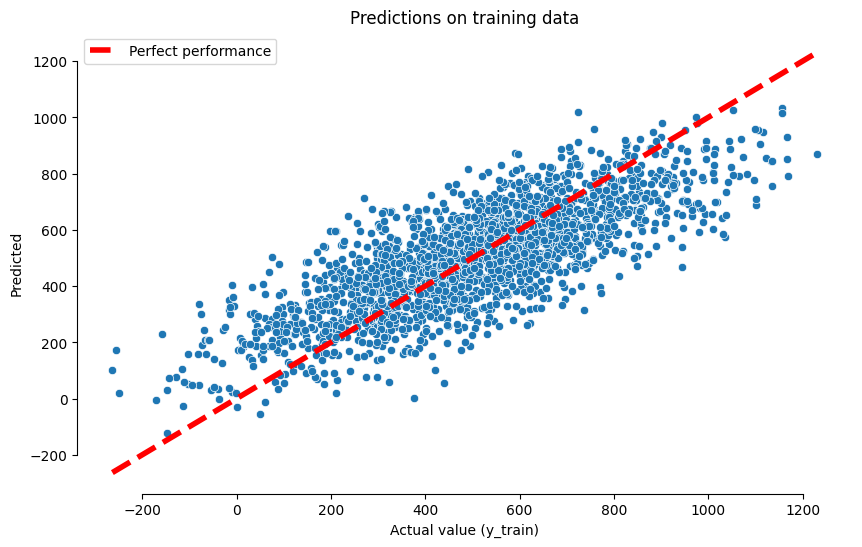

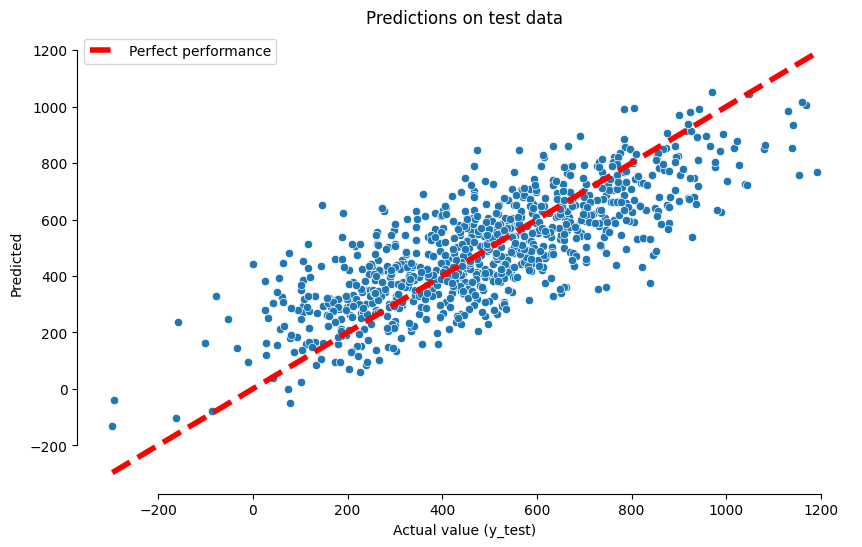

In [22]:
# Let's plot our predictions against the real values
y_train_pred = pipeline.predict(my_dataset.X_train)
y_test_pred = pipeline.predict(my_dataset.X_test)
_plotting_axes = psml.plot_reg_prediction_errors(
    y_train=my_dataset.y_train,
    y_train_pred=y_train_pred,
    y_test=my_dataset.y_test,
    y_test_pred=y_test_pred,
)